In [1]:
import os
import re
import json
import torch
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from transformers import AutoModelForCausalLM, AutoTokenizer
import outlines # see https://dottxt-ai.github.io/outlines/latest/features/models/transformers/
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Literal
from itertools import combinations

from data_loader import load_dataset, format_input_with_context


In [2]:
MODEL_NAME = 'meta-llama/Llama-3.2-3B-Instruct'
USE_CTX = False # whether to use [CTX] parts of threads (too slow for True)
MAX_COT_TOKENS = 200 # max n tokens for cot response
VALID_STANCES = ['SUPPORT', 'DENY', 'QUERY', 'COMMENT']
RELOAD_MODEL = False # takes up lots of mem if we keep reloading

RESULTS_DIR = "./results/prompting/" # set to None to not save results
RANDOM_SEED = 42
if RESULTS_DIR: os.makedirs(RESULTS_DIR, exist_ok=True)
np.random.seed(RANDOM_SEED)

# load data
train_df, dev_df, test_df = load_dataset()

Loading cached data from saved_data/datasets.pkl...


In [3]:
# load model

# output types for outlines
StanceLabel = Literal["SUPPORT", "DENY", "QUERY", "COMMENT"]
COT_REGEX = outlines.types.Regex(r"[\s\S]*Label: (SUPPORT|DENY|QUERY|COMMENT)")

if 'model' not in globals() or RELOAD_MODEL:
    hf_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        dtype=torch.float16,
        device_map='auto',
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    
    # use outlines
    model = outlines.from_transformers(hf_model, tokenizer)
    
    # get rid of annoying warnings re pad_token
    model.tokenizer.pad_token = tokenizer.eos_token
    model.tokenizer.padding_side = "left"
    model.model.generation_config.pad_token_id = model.tokenizer.pad_token_id

print(MODEL_NAME)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

meta-llama/Llama-3.2-3B-Instruct


In [4]:
# prompts
# see https://huggingface.co/docs/transformers/en/tasks/prompting
# https://www.promptingguide.ai/techniques/zeroshot

PERSONA = """You are an expert in rumour stance analysis on twitter."""
INSTRUCTION = """Your task is to classify the stance of the [TARGET] tweet towards the veracity of the rumour in the [SRC] tweet."""
INPUT_FORMAT = """\
The input will be provided as a single string containing labeled segments:
"[SRC] ... [PARENT] ... [TARGET] ...". (Note: [PARENT] is omitted if [TARGET] replies directly to [SRC])
"""
LABEL_DEFNS = """\
Classification Labels:
- SUPPORT: The reply explicitly supports or provides evidence for the veracity of the source claim
- DENY: The tweet explicitly denies or provides counter-evidence for the veracity of the source claim
- QUERY: The reply asks for additional evidence in relation to the veracity of the source claim
- COMMENT: The reply makes their own opinionated/neutral comment without a clear contribution to assessing the veracity of the source claim
"""

SYS_PROMPT = f"""\
{PERSONA}
{INSTRUCTION}
{INPUT_FORMAT}
{LABEL_DEFNS}
"""
# output format set by outlines

USER_PROMPT_TEMPLATE = """\
Text: {thread_context}

Classify the stance of [TARGET] towards the veracity of the rumour in [SRC]:
"""

def build_user_prompt(thread_context):
    return USER_PROMPT_TEMPLATE.format(thread_context=thread_context)


def build_messages(thread_context, examples=None, sys_prompt=None):
    init_prompt = sys_prompt if sys_prompt is not None else SYS_PROMPT # allow custom sys prompt (eg. for CoT/ablations)
    messages = [{"role": "system", "content": init_prompt}]
    if examples: # for few-shot
        for ex in examples:
            messages.append({"role": "user", "content": build_user_prompt(ex['source'])})
            messages.append({"role": "assistant", "content": ex['response']})
    messages.append({"role": "user", "content": build_user_prompt(thread_context)}) # final user prompt to answer
    return messages

def build_ablation_sys_prompt(component_keys): # ablated sys prompt
    if not component_keys:
        return ""
    return "\n".join(PROMPT_COMPONENTS[k] for k in component_keys)



In [5]:
# COT prompts 

# add output format to think step by step
COT_OUTPUT_FORMAT = """\
Your response should follow this EXACT format:
Reasoning: [VERY BRIEFLY explain why the label fits. Use a two stage strategy: Stage 1 classify Stance vs Non-Stance - If Non-stance, skip stage 2 and answer 'COMMENT'. Otherwise: Stage 2 classify Support / Deny / Query]
Label: [EXACTLY one of: SUPPORT, DENY, QUERY, or COMMENT]
"""

COT_SYS_PROMPT = f"""\
{PERSONA}
{INSTRUCTION}
{INPUT_FORMAT}
{LABEL_DEFNS}
{COT_OUTPUT_FORMAT}
"""

# for few-shot cot

# handselected ids for reasoning
COT_FEW_SHOT_IDS = {
    'support': '524967134339022848', # @TheKirkness Radio Canada tweeting same. must be true :-(
    'deny': '544292581950357504', # @JSchoenberger7 @TheAnonMessage not an Isis flag. Just an Islamic one. Stop spreading false rumors.
    'query': '544281192632053761', # @mscott Are your reporters 100% sure it is an ISIS flag? Cause that is what is being reported. #facts
    'comment': '552804023389392896', # @thei100 @Independent these fuckers thinking its a GTA heist mission
}

COT_EXAMPLES = {
    'support': "1. Stance: takes position on veracity\n2. \"must be true\" → affirms claim\nLabel: SUPPORT",
    'deny': "1. Stance: challenges veracity\n2. \"not an Isis flag\", \"false rumors\" → rejects claim\nLabel: DENY",
    'query': "1. Stance: engages with veracity\n2. \"Are your reporters 100% sure?\" → requests evidence\nLabel: QUERY",
    'comment': "1. Stance: no veracity assessment\n2. Offers opinion/reaction only\nLabel: COMMENT",
}

def get_cot_examples(train_df):
    examples = []
    for label, tweet_id in COT_FEW_SHOT_IDS.items():
        matches = train_df[train_df['tweet_id'] == tweet_id]
        if len(matches) == 0:
            print(f"Warning: COT example tweet_id {tweet_id} not found")
            continue
        row = matches.iloc[0]
        examples.append({
            'source': format_input_with_context(row, train_df, use_features=False, use_context=USE_CTX),
            'response': COT_EXAMPLES[label]
        })
    return examples

In [6]:
def parse_cot_label(text): # get final label from cot response
    match = re.search(r'Label:\s*(SUPPORT|DENY|QUERY|COMMENT)', text, re.IGNORECASE)
    return match.group(1).lower() if match else None

In [7]:
# few shot examples

# from different sources and topics
DIVERSE_FEW_SHOT_IDS = {
    'support': '553486439129038848', # 'BREAKING: French police tell AP suspects in #CharlieHebdo attack have taken a hostage northeast of Paris.'
    'deny': '500384255814299648', # '@TPM @McBlondeLand Awful! The DOJ needs to do thorough investigation of this PD-these problems are systemic. The citizens deserve better!'
    'query': '525003827494531073', # '@CTVNews @ctvsaskatoon so what happened at Rideau? Nothing?'
    'comment': '544314008980172800', # "@WilliamsJon @morgfair how do we know the guy isn't just pissed that he got fired or foreclosed on. Or his gf is cheating on him."
}
    
# From same source thread
SAME_SRC_SOURCE_ID = '529739968470867968' # 'Prince not playing Massey Hall tonight, promoter says http://t.co/clVHvM07kx http://t.co/IADirsFOOC'
SAME_SRC_FEW_SHOT_IDS = {
    'support': '529740822238232577', # 'athenaph what tease!!! RT @CBCNews: Prince not playing Massey Hall tonight, promoter says http://t.co/245JKmwWHH'
    'deny': '529740809672077313', # '.@CBCNews I can also confirm he will not be playing in Rankin Inlet, NU either'
    'query': '529748991849013248', # '@CBCNews And, ... ?\nWhen @CBCNews asked Live Nation why no one made this clarification 4 or 5 hours earlier?'
    'comment': '529741574742507520', # '@CBCNews  lol.'
}

# random stratified selection (one per stance but randomly picked)
RANDOM_STRATIFIED_FEW_SHOT_IDS = {
    'support': '544306719686656000', # 'US evacuated Consulate in Sydney after #sydneysiege. Emergency warning to U.S. citizens urging them to "maintain high level of vigilance".'
    'deny': '524990163446140928', # 'Police have clarified that there were two shootings in Ottawa today, not three: at the War Memorial and Parliament Hill.'
    'query': '500386447158161408', # '@TPM Wow. I thought a Tweep was being sarcastic, but...it really happened that way?!?'
    'comment': '553543395717550080', # '@FoxNews @Machma7Machos the terrorists need empathy send them to Harvard University'
}

FEW_SHOT_SETS = {
    'diverse': DIVERSE_FEW_SHOT_IDS,
    'same_src': SAME_SRC_FEW_SHOT_IDS,
    'random': RANDOM_STRATIFIED_FEW_SHOT_IDS,
}


def get_few_shot_examples(df, n_per_class=1, use_set=None, classes=None):
    if classes is None:
        classes = ['support', 'deny', 'query', 'comment']
    examples = []
    
    if use_set is not None:
        # deterministic using defined sets
        if use_set not in FEW_SHOT_SETS:
            raise ValueError(f"Unknown use_set '{use_set}'. Choose from: {list(FEW_SHOT_SETS.keys())}")
        
        id_dict = FEW_SHOT_SETS[use_set]
        for label in classes:
            tweet_id = id_dict.get(label)
            if tweet_id is None:
                continue
            matches = df[df['tweet_id'] == tweet_id]
            if len(matches) == 0:
                print(f"Warning: Few-shot example tweet_id {tweet_id} not found in df")
                continue
            row = matches.iloc[0]
            examples.append({
                'source': format_input_with_context(row, df, use_features=False, use_context=USE_CTX),
                'response': label.upper()
            })
    else:
        # Non-deterministic: random stratified sampling
        for label in classes:
            class_df = df[df['label_text'] == label]
            samples = class_df.sample(n=min(n_per_class, len(class_df)))
            
            for _, row in samples.iterrows():
                examples.append({
                    'source': format_input_with_context(row, df, use_features=False, use_context=USE_CTX),
                    'response': label.upper()
                })
    
    return examples
    


In [8]:
def evaluate_prompting(model, df, mode="zero-shot", examples=None, sys_prompt_override=None, verbose=True, save_name=None):
    # mode can be zero-shot or cot (for few-shot, just pass list into examples)
    # sys_prompt_override is just for ablations (cot sys prompt added automatically)
    # save_name = None if you don't want to save the confusion matrix and predictions csv

    # set output params
    if mode == "cot":
        output_type = COT_REGEX
        max_new_tokens = MAX_COT_TOKENS
    else:
        output_type = StanceLabel
        max_new_tokens = 10
    
    # allow custom sys prompt for ablations & cot
    if sys_prompt_override is not None:
        active_sys_prompt = sys_prompt_override
    elif mode == "cot":
        active_sys_prompt = COT_SYS_PROMPT
    else:
        active_sys_prompt = SYS_PROMPT
    
    predictions = []
    raw_responses = []
    error_count = 0 # track cot errors where it doesn't return label
    err_ids = []
    err_responses = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Eval ({mode})"):
        input_text = format_input_with_context(row, df, use_features=False, use_context=USE_CTX) # format with [SRC] etc
        messages = build_messages(input_text, examples=examples, sys_prompt=active_sys_prompt) # get messages dict
        prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True) # get prompt string
        response = model(prompt, output_type, max_new_tokens=max_new_tokens) # get response
        raw_responses.append(response)

        if mode == "cot":
            pred = parse_cot_label(response) # may return none if didn't give label
            if pred is None:
                error_count += 1
                err_ids.append(row['tweet_id'])
                err_responses.append(response)
                pred = 'comment' # so default to 'comment' as majority class
        else:
            pred = response.lower().strip()
        predictions.append(pred)
    
    true_labels = df['label_text'].tolist()
    labels = ['support', 'deny', 'query', 'comment']
    macro_f1 = f1_score(true_labels, predictions, average='macro')
    per_class_f1 = f1_score(true_labels, predictions, average=None, labels=labels)
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    if verbose:
        if error_count > 0:
            print(f"{error_count} ERRORS")
            for i in range(error_count):
                    print(f"Tweet id: {err_ids[i]}\nResponse: '{err_responses[i]}'\n" + "-" * 30)
                    if i > 5:
                        break # only show 1st 5
        print(f"\n{classification_report(true_labels, predictions, labels=labels, zero_division=0.0)}")
    
    # plot confusion matrix (use seaborn)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, 
                cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix: {save_name or mode}')
    plt.tight_layout()
    
    # save results if enabled
    if RESULTS_DIR and save_name:
        # save predictions csv
        results_df = pd.DataFrame({'true_label': true_labels, 'predicted': predictions})
        results_df.to_csv(f"{RESULTS_DIR}predictions_{save_name}.csv", index=False)
        
        # save confusion matrix png
        plt.savefig(f"{RESULTS_DIR}confusion_matrix_{save_name}.png", dpi=150)
        if verbose:
            print(f"Saved: predictions_{save_name}.csv, confusion_matrix_{save_name}.png")
    
    plt.show()
    plt.close()

    return {
        'macro_f1': macro_f1,
        'per_class_f1': dict(zip(labels, per_class_f1)),
        'confusion_matrix': cm,
        'predictions_vs_responses': list(zip(predictions, raw_responses)),
        'error_ids_vs_responses': list(zip(err_ids, err_responses)) if error_count > 0 else None
    }

## Zero-shot

Eval (zero-shot):   0%|          | 0/1049 [00:00<?, ?it/s]


              precision    recall  f1-score   support

     support       0.23      0.03      0.06        94
        deny       0.12      0.68      0.21        71
       query       0.15      0.91      0.26       106
     comment       0.89      0.01      0.02       778

    accuracy                           0.15      1049
   macro avg       0.35      0.41      0.14      1049
weighted avg       0.70      0.15      0.06      1049

Saved: predictions_zero-shot.csv, confusion_matrix_zero-shot.png


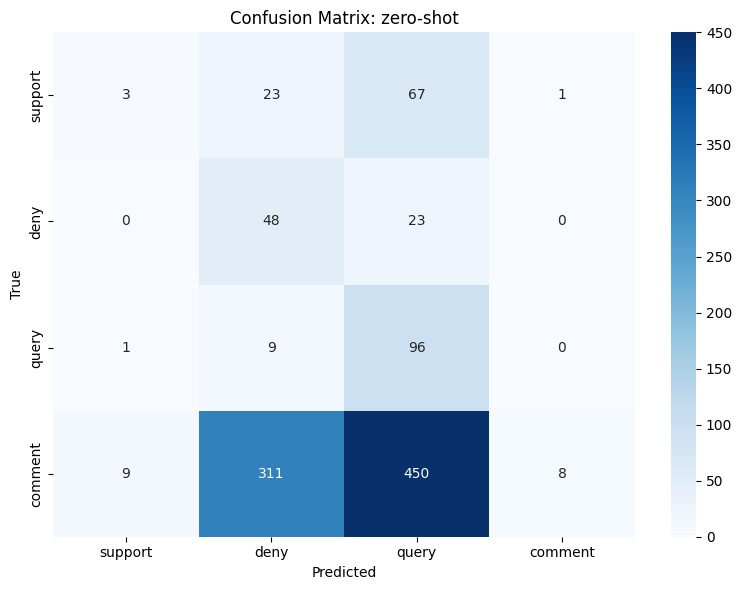

In [9]:
# zero-shot
zero_results = evaluate_prompting(model, test_df, mode="zero-shot", save_name="zero-shot")

## Few-shot

Eval (few-shot):   0%|          | 0/1049 [00:00<?, ?it/s]


              precision    recall  f1-score   support

     support       0.16      0.60      0.26        94
        deny       0.17      0.28      0.21        71
       query       0.24      0.82      0.37       106
     comment       0.85      0.24      0.37       778

    accuracy                           0.33      1049
   macro avg       0.35      0.48      0.30      1049
weighted avg       0.68      0.33      0.35      1049

Saved: predictions_few-shot.csv, confusion_matrix_few-shot.png


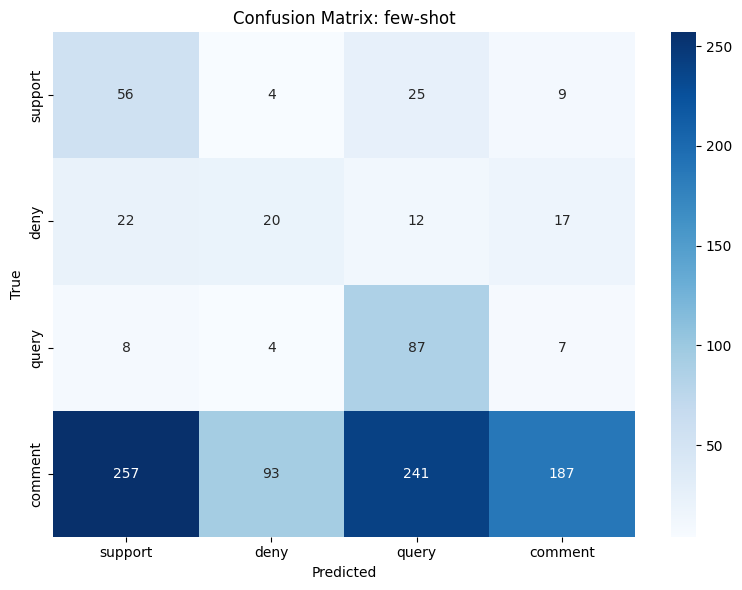

In [10]:
# few-shot
few_shot_examples = get_few_shot_examples(train_df, n_per_class=1)
few_results = evaluate_prompting(model, test_df, mode="few-shot", examples=few_shot_examples, save_name="few-shot")

## CoT Prompting

In [ ]:
# CoT prompting
cot_results = evaluate_prompting(model, test_df, mode="cot", examples=None, save_name="cot")


Eval (cot):   0%|          | 0/1049 [00:00<?, ?it/s]

In [ ]:
# few shot cot
cot_few_shot_examples = get_cot_examples(train_df)
cot_few_results = evaluate_prompting(model, test_df, mode="cot", examples=cot_few_shot_examples, save_name="few-shot-cot")

# Experiments

These take a long time to run, so I've put the csvs remotely on github to see the plotsd

In [12]:
sns.set_theme(style="whitegrid", font_scale=1.4)

# custom palette for sys prompt ablation (exp 1)
custom_ablation_palette = sns.color_palette()
custom_ablation_palette = [(0.82745098, 0.82745098, 0.82745098)] + custom_ablation_palette # grey for no sys prompt
custom_ablation_palette[5] = (0,0,0) # black for full sys prompt

# helpers
def load_or_create_csv(path, columns):
    if os.path.exists(path):
        return pd.read_csv(path)
    return pd.DataFrame(columns=columns)


def append_row_to_csv(path, row_dict):
    df = pd.DataFrame([row_dict])
    df.to_csv(path, mode='a', header=not os.path.exists(path), index=False)



In [ ]:
# sys prompt ablation

PROMPT_COMPONENTS = {
    'persona': PERSONA,
    'instruction': INSTRUCTION,
    'input_format': INPUT_FORMAT,
    'label_defns': LABEL_DEFNS,
}

ISOLATED_CONFIGS = {
    'minimal': [],
    '+persona': ['persona'],
    '+instruction': ['instruction'],
    '+input_format': ['input_format'],
    '+label_defns': ['label_defns'],
    'full': ['persona', 'instruction', 'input_format', 'label_defns'],
}

CUMULATIVE_CONFIGS = {
    'minimal': [],
    '+persona': ['persona'],
    '+instruction': ['persona', 'instruction'],
    '+input_format': ['persona', 'instruction', 'input_format'],
    '+label_defns (full)': ['persona', 'instruction', 'input_format', 'label_defns'],
}

def run_exp1_ablation(model, tokenizer, train_df, dev_df):    
    csv_path = f"{RESULTS_DIR}exp1_ablation.csv"
    columns = ['config_type', 'config_name', 'macro_f1']
    
    existing_df = load_or_create_csv(csv_path, columns)
    completed = set(zip(existing_df.get('config_type', []), existing_df.get('config_name', [])))
    
    all_configs = [
        ('isolated', ISOLATED_CONFIGS),
        ('cumulative', CUMULATIVE_CONFIGS),
    ]
    
    for config_type, configs in all_configs:
        for config_name, component_keys in configs.items():
            if (config_type, config_name) in completed:
                print(f"  Skipping {config_type}/{config_name} (already done)")
                continue
            
            sys_prompt = build_ablation_sys_prompt(component_keys)
            results = evaluate_prompting(model, dev_df, mode="zero-shot", 
                                         sys_prompt_override=sys_prompt, verbose=False)
            
            row = {'config_type': config_type, 'config_name': config_name, 'macro_f1': results['macro_f1']}
            append_row_to_csv(csv_path, row)
            print(f"  {config_type}/{config_name}: {results['macro_f1']:.4f}")
    
    print(f"Results saved to {csv_path}")

In [ ]:
# few shot selection strategy chart
def run_exp2_fewshot_strategies(model, tokenizer, train_df, dev_df):    
    csv_path = f"{RESULTS_DIR}exp2_fewshot_strategies.csv"
    columns = ['strategy', 'n_per_class', 'macro_f1', 'support_f1', 'deny_f1', 'query_f1', 'comment_f1']
    
    existing_df = load_or_create_csv(csv_path, columns)
    completed = set(zip(existing_df.get('strategy', []), existing_df.get('n_per_class', [])))
    
    strategies = ['diverse', 'same_src', 'random']
    n_values = [1, 2, 3]
    
    for strategy in strategies:
        for n in n_values:
            if (strategy, n) in completed:
                print(f"  Skipping {strategy}/n={n} (already done)")
                continue
            
            examples = get_few_shot_examples(train_df, n_per_class=n, use_set=strategy)
            results = evaluate_prompting(model, dev_df, mode="few-shot", examples=examples, verbose=False)
            
            row = {
                'strategy': strategy, 
                'n_per_class': n, 
                'macro_f1': results['macro_f1'],
                **{f"{k}_f1": v for k, v in results['per_class_f1'].items()}
            }
            append_row_to_csv(csv_path, row)
            print(f"  {strategy}/n={n}: macro_f1={results['macro_f1']:.4f}")
    
    print(f"Results saved to {csv_path}")

In [ ]:
# class importance in few shot examples
def run_exp3_class_importance(model, tokenizer, train_df, dev_df):    
    csv_path = f"{RESULTS_DIR}exp3_class_importance.csv"
    columns = ['combo_name', 'classes', 'support_f1', 'deny_f1', 'query_f1', 'comment_f1', 'macro_f1']
    
    existing_df = load_or_create_csv(csv_path, columns)
    completed = set(existing_df.get('combo_name', []))
    
    all_classes = ['support', 'deny', 'query', 'comment']
    class_abbrev = {'support': 'S', 'deny': 'D', 'query': 'Q', 'comment': 'C'}
    
    # generate all combinations: 1-shot singles, 2-shot pairs, 3-shot triples, 4-shot full
    combos = []
    for r in range(1, 5):
        for combo in combinations(all_classes, r):
            combos.append(list(combo))
    
    for classes in combos:
        combo_name = f"{len(classes)}-shot: " + "+".join(class_abbrev[c] for c in classes)
        
        if combo_name in completed:
            print(f"  Skipping {combo_name} (already done)")
            continue
        
        examples = get_few_shot_examples(train_df, n_per_class=1, use_set='diverse', classes=classes)
        results = evaluate_prompting(model, dev_df, mode="few-shot", examples=examples, verbose=False)
        
        row = {
            'combo_name': combo_name, 
            'classes': '+'.join(classes), 
            'macro_f1': results['macro_f1'],
            **{f"{k}_f1": v for k, v in results['per_class_f1'].items()}
        }
        append_row_to_csv(csv_path, row)
        print(f"  {combo_name}: macro_f1={results['macro_f1']:.4f}")
    
    print(f"Results saved to {csv_path}")

In [ ]:
# comparison between all methods
def run_exp4_test_final(model, tokenizer, train_df, test_df):
    csv_path = f"{RESULTS_DIR}exp4_test_final.csv"
    columns = ['strategy', 'repeat', 'macro_f1', 'support_f1', 'deny_f1', 'query_f1', 'comment_f1']
    
    existing_df = load_or_create_csv(csv_path, columns)
    completed = set(zip(existing_df.get('strategy', []), existing_df.get('repeat', [])))
    
    strategies = ['zero-shot', 'few-shot', 'cot', 'few-shot-cot']
    n_repeats = 3
    
    for strategy in strategies:
        for repeat in range(1, n_repeats + 1):
            if (strategy, repeat) in completed:
                print(f"  Skipping {strategy}/repeat={repeat} (already done)")
                continue
            
            # Configure examples based on strategy
            if strategy == 'zero-shot':
                examples = None
                mode = 'zero-shot'
            elif strategy == 'few-shot':
                examples = get_few_shot_examples(train_df, n_per_class=1, use_set='diverse')
                mode = 'few-shot'
            elif strategy == 'cot':
                examples = None
                mode = 'cot'
            elif strategy == 'few-shot-cot':
                examples = get_cot_examples(train_df)
                mode = 'cot'
            
            results = evaluate_prompting(model, test_df, mode=mode, examples=examples, verbose=False)
            
            row = {
                'strategy': strategy, 
                'repeat': repeat, 
                'macro_f1': results['macro_f1'],
                **{f"{k}_f1": v for k, v in results['per_class_f1'].items()}
            }
            append_row_to_csv(csv_path, row)
            print(f"  {strategy}/repeat={repeat}: macro_f1={results['macro_f1']:.4f}")
    
    print(f"Results saved to {csv_path}")

In [40]:
# get plots from experiment csvs if they exist
# (seperate so i don't have to run experiment again to edit graph)
def generate_all_plots():    
    # system prompt ablation
    csv_path = f"{RESULTS_DIR}exp1_ablation.csv"
    if os.path.exists(csv_path):
        results_df = pd.read_csv(csv_path)
        for config_type in ['isolated', 'cumulative']:
            subset = results_df[results_df['config_type'] == config_type]
            if len(subset) > 0:
                fig, ax = plt.subplots(figsize=(10, 6))
                sns.barplot(data=subset, y='config_name', x='macro_f1', hue='config_name', palette=custom_ablation_palette, ax=ax)
                ax.set_xlabel('Macro F1')
                ax.set_ylabel('')
                ax.set_title(f'System Prompt Ablation: {config_type.title()}')
                plt.tight_layout()
                plt.savefig(f"{RESULTS_DIR}exp1_ablation_{config_type}.png", dpi=150)
                plt.close()
    
    # few-shot seletion strategies
    csv_path = f"{RESULTS_DIR}exp2_fewshot_strategies.csv"
    if os.path.exists(csv_path):
        results_df = pd.read_csv(csv_path)
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(data=results_df, x='n_per_class', y='macro_f1', hue='strategy', ax=ax)
        ax.set_xlabel('Examples per Stance')
        ax.set_ylabel('Macro F1')
        ax.set_title('Few-shot Strategy Comparison')
        ax.legend(title='Strategy', loc='lower right')
        plt.tight_layout()
        plt.savefig(f"{RESULTS_DIR}exp2_fewshot_strategies.png", dpi=150)
        plt.close()
    
    # few shot class importance heatmap
    csv_path = f"{RESULTS_DIR}exp3_class_importance.csv"
    if os.path.exists(csv_path):
        results_df = pd.read_csv(csv_path)
        heatmap_data = results_df.set_index('combo_name')[['support_f1', 'deny_f1', 'query_f1', 'comment_f1', 'macro_f1']]
        fig, ax = plt.subplots(figsize=(10, 12))
        sns.heatmap(heatmap_data, annot=True, fmt='.2f', ax=ax, vmin=0.15, vmax=0.65)
        ax.set_title('Class Importance in Few-shot Examples')
        ax.set_xlabel('F1 Score')
        ax.set_ylabel('Few-shot Combination')
        plt.tight_layout()
        plt.savefig(f"{RESULTS_DIR}exp3_class_importance.png", dpi=150)
        plt.close()
    
    # comparison between all classification methods
    csv_path = f"{RESULTS_DIR}exp4_test_final.csv"
    if os.path.exists(csv_path):
        results_df = pd.read_csv(csv_path)
        # results_df = results_df[results_df['strategy'] != 'classifier']
        if len(results_df) > 0:
            summary = results_df.groupby('strategy')['macro_f1'].agg(['mean', 'std']).reset_index()
            summary.columns = ['strategy', 'mean_f1', 'std_f1']
            order = ['classifier', 'zero-shot', 'few-shot', 'cot', 'few-shot-cot']
            summary['strategy'] = pd.Categorical(summary['strategy'], categories=order, ordered=True)
            summary = summary.sort_values('strategy')
            
            fig, ax = plt.subplots(figsize=(10, 6))
            bars = ax.bar(summary['strategy'], summary['mean_f1'], yerr=summary['std_f1'], capsize=5)
            ax.set_xlabel('Strategy')
            ax.set_ylabel('Macro F1 (mean ± std)')
            ax.set_title('Test Set Performance Comparison (3 repeats)')
            ax.set_ylim(0, 0.75)
            for bar, mean in zip(bars, summary['mean_f1']):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{mean:.3f}', 
                        ha='center', va='bottom', fontsize=10)
            plt.tight_layout()
            plt.savefig(f"{RESULTS_DIR}exp4_test_final.png", dpi=150)
            plt.close()
    
    print("Plots saved.")


In [41]:
# USAGE
# run_exp1_ablation(model, tokenizer, train_df, dev_df)
# run_exp2_fewshot_strategies(model, tokenizer, train_df, dev_df)
# run_exp3_class_importance(model, tokenizer, train_df, dev_df)
# run_exp4_test_final(model, tokenizer, train_df, test_df)

generate_all_plots()

/var/folders/gl/db7nsz8j70v_n0_38tnxspz80000gn/T/ipykernel_72266/3753050664.py:12: UserWarning: The palette list has more values (11) than needed (6), which may not be intended.
  sns.barplot(data=subset, y='config_name', x='macro_f1', hue='config_name', palette=custom_ablation_palette, ax=ax)
/var/folders/gl/db7nsz8j70v_n0_38tnxspz80000gn/T/ipykernel_72266/3753050664.py:12: UserWarning: The palette list has more values (11) than needed (5), which may not be intended.
  sns.barplot(data=subset, y='config_name', x='macro_f1', hue='config_name', palette=custom_ablation_palette, ax=ax)


Plots saved.
